In [1]:
suppressPackageStartupMessages(library(plyr))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(tibble))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(patchwork))
suppressPackageStartupMessages(library(stringr))
library(hise)
library(parallel)
library(introdataviz)

# 4 time point

In [39]:
cell_counts<-read.csv('/home//jupyter/BRI_Analysis/scRNA/cell_counts_BRI.csv',check.names = FALSE)
celltypes<-colnames(cell_counts)[3:73]

In [40]:
meta_data<-read.csv('/home//jupyter/BRI_Analysis/scRNA/hise_meta_data_2024-01-23_fixed.csv')
meta_data<-meta_data %>% filter(Covid_exlcusion=='no')
meta_data<-meta_data %>% filter(sample.visitName %in% c('Flu Year 1 Day 0','Flu Year 1 Day 90','Flu Year 2 Day 0','Flu Year 2 Day 90'))

In [41]:
meta<-unique(meta_data[c('subject.subjectGuid','CMV.IgG.Serology.Result.Interpretation','subject.biologicalSex','cohort.cohortGuid')])

In [42]:
colnames(meta)<-c('donor','CMV','Sex','cohort.cohortGuid')

In [43]:
cell_counts<-left_join(meta_data,cell_counts)

Joining with `by = join_by(pbmc_sample_id)`


In [44]:
CV_Res_FILES<-list.files(path = "01A_CV_4_timepoint/", pattern = "csv", all.files = TRUE,
           full.names = TRUE, recursive = FALSE,
           ignore.case = TRUE, include.dirs = TRUE, no.. = FALSE)

In [45]:
CV_Res_meta<-as.data.frame(CV_Res_FILES)

In [46]:
CV_Res_meta<-CV_Res_meta %>%
  mutate(    after_slash = str_extract(CV_Res_FILES, "(?<=//).+"),
    donor = str_extract(CV_Res_FILES, "(?<=//)[^_]+"),
    celltype = str_extract(after_slash, "(?<=_)[^.]+(?=\\.csv)") )%>%
  select(-after_slash)

In [47]:
CV_Res_meta<-left_join(CV_Res_meta,meta)

Joining with `by = join_by(donor)`


In [48]:
counts_df_minCell <- data.frame()  

for (i in celltypes) {
cell_counts_subset<-cell_counts[c('pbmc_sample_id',i)]
pbmc_sample_id_filtered<-cell_counts_subset[cell_counts_subset[i]>10,]$pbmc_sample_id      
    meta_data_subset <- meta_data %>% filter(pbmc_sample_id %in% pbmc_sample_id_filtered)

    # Check if meta_data_subset is empty
    if (nrow(meta_data_subset) == 0) {
        next  # Skip to the next iteration if no data
    }

    sample_counts <- as.data.frame(table(meta_data_subset$subject.subjectGuid))
    sample_counts$celltypes <- i
    
    colnames(sample_counts) <- c('donor', 'number_of_timepoint_with_minCell', 'celltypes')
    counts_df_minCell <- rbind.fill(counts_df_minCell, sample_counts)
}
counts_df_minCell$celltypes<-gsub(' ','_',counts_df_minCell$celltypes)

In [49]:

df_list<-mclapply(pull(CV_Res_meta['CV_Res_FILES']),function(x){
df<-read.csv(x) %>% filter(mean>=0.1)
return(df)
},mc.cores=60)


In [50]:
df_all<-do.call(rbind, df_list)
df_all<-left_join(df_all,meta)

Joining with `by = join_by(donor)`


In [51]:
df_all<-left_join(df_all,counts_df_minCell)

Joining with `by = join_by(celltypes, donor)`


In [52]:
# filter out samples does not contian 4 time point and genes has zero expression in any of 4 time point

df_all<-df_all %>% filter(number_of_timepoint==4,number_of_timepoint_non_zero_expr==4,number_of_timepoint_with_minCell==4)

In [53]:
df=as.data.frame(table(df_all$X,df_all$celltypes,df_all$cohort.cohortGuid))
colnames(df)<-c('X',"celltypes",'cohort.cohortGuid','donor_counts')

In [54]:
df_all_averge<-df_all %>% group_by(celltypes,X,cohort.cohortGuid) %>%   
                    dplyr::summarise(cv_average = mean(cv),
                                     mean_average = mean(mean),
                                    variance_average = mean(variance),
                                    sd_average = mean(sd),) 

`summarise()` has grouped output by 'celltypes', 'X'. You can override using
the `.groups` argument.


In [55]:
# filter gene by at least 10 donor in each cohorts

df_all_averge<-left_join(df_all_averge,df)
df_all_averge<-df_all_averge %>%
  group_by(celltypes,X) %>%
  filter(all(donor_counts > 10)) %>%
  ungroup()

Joining with `by = join_by(celltypes, X, cohort.cohortGuid)`


In [56]:
selected_celltype<-as.data.frame(table(df_all_averge$celltypes,df_all_averge$cohort.cohortGuid)) %>%
  group_by(Var1) %>%
  filter(all(Freq > 1000)) %>%
  ungroup()

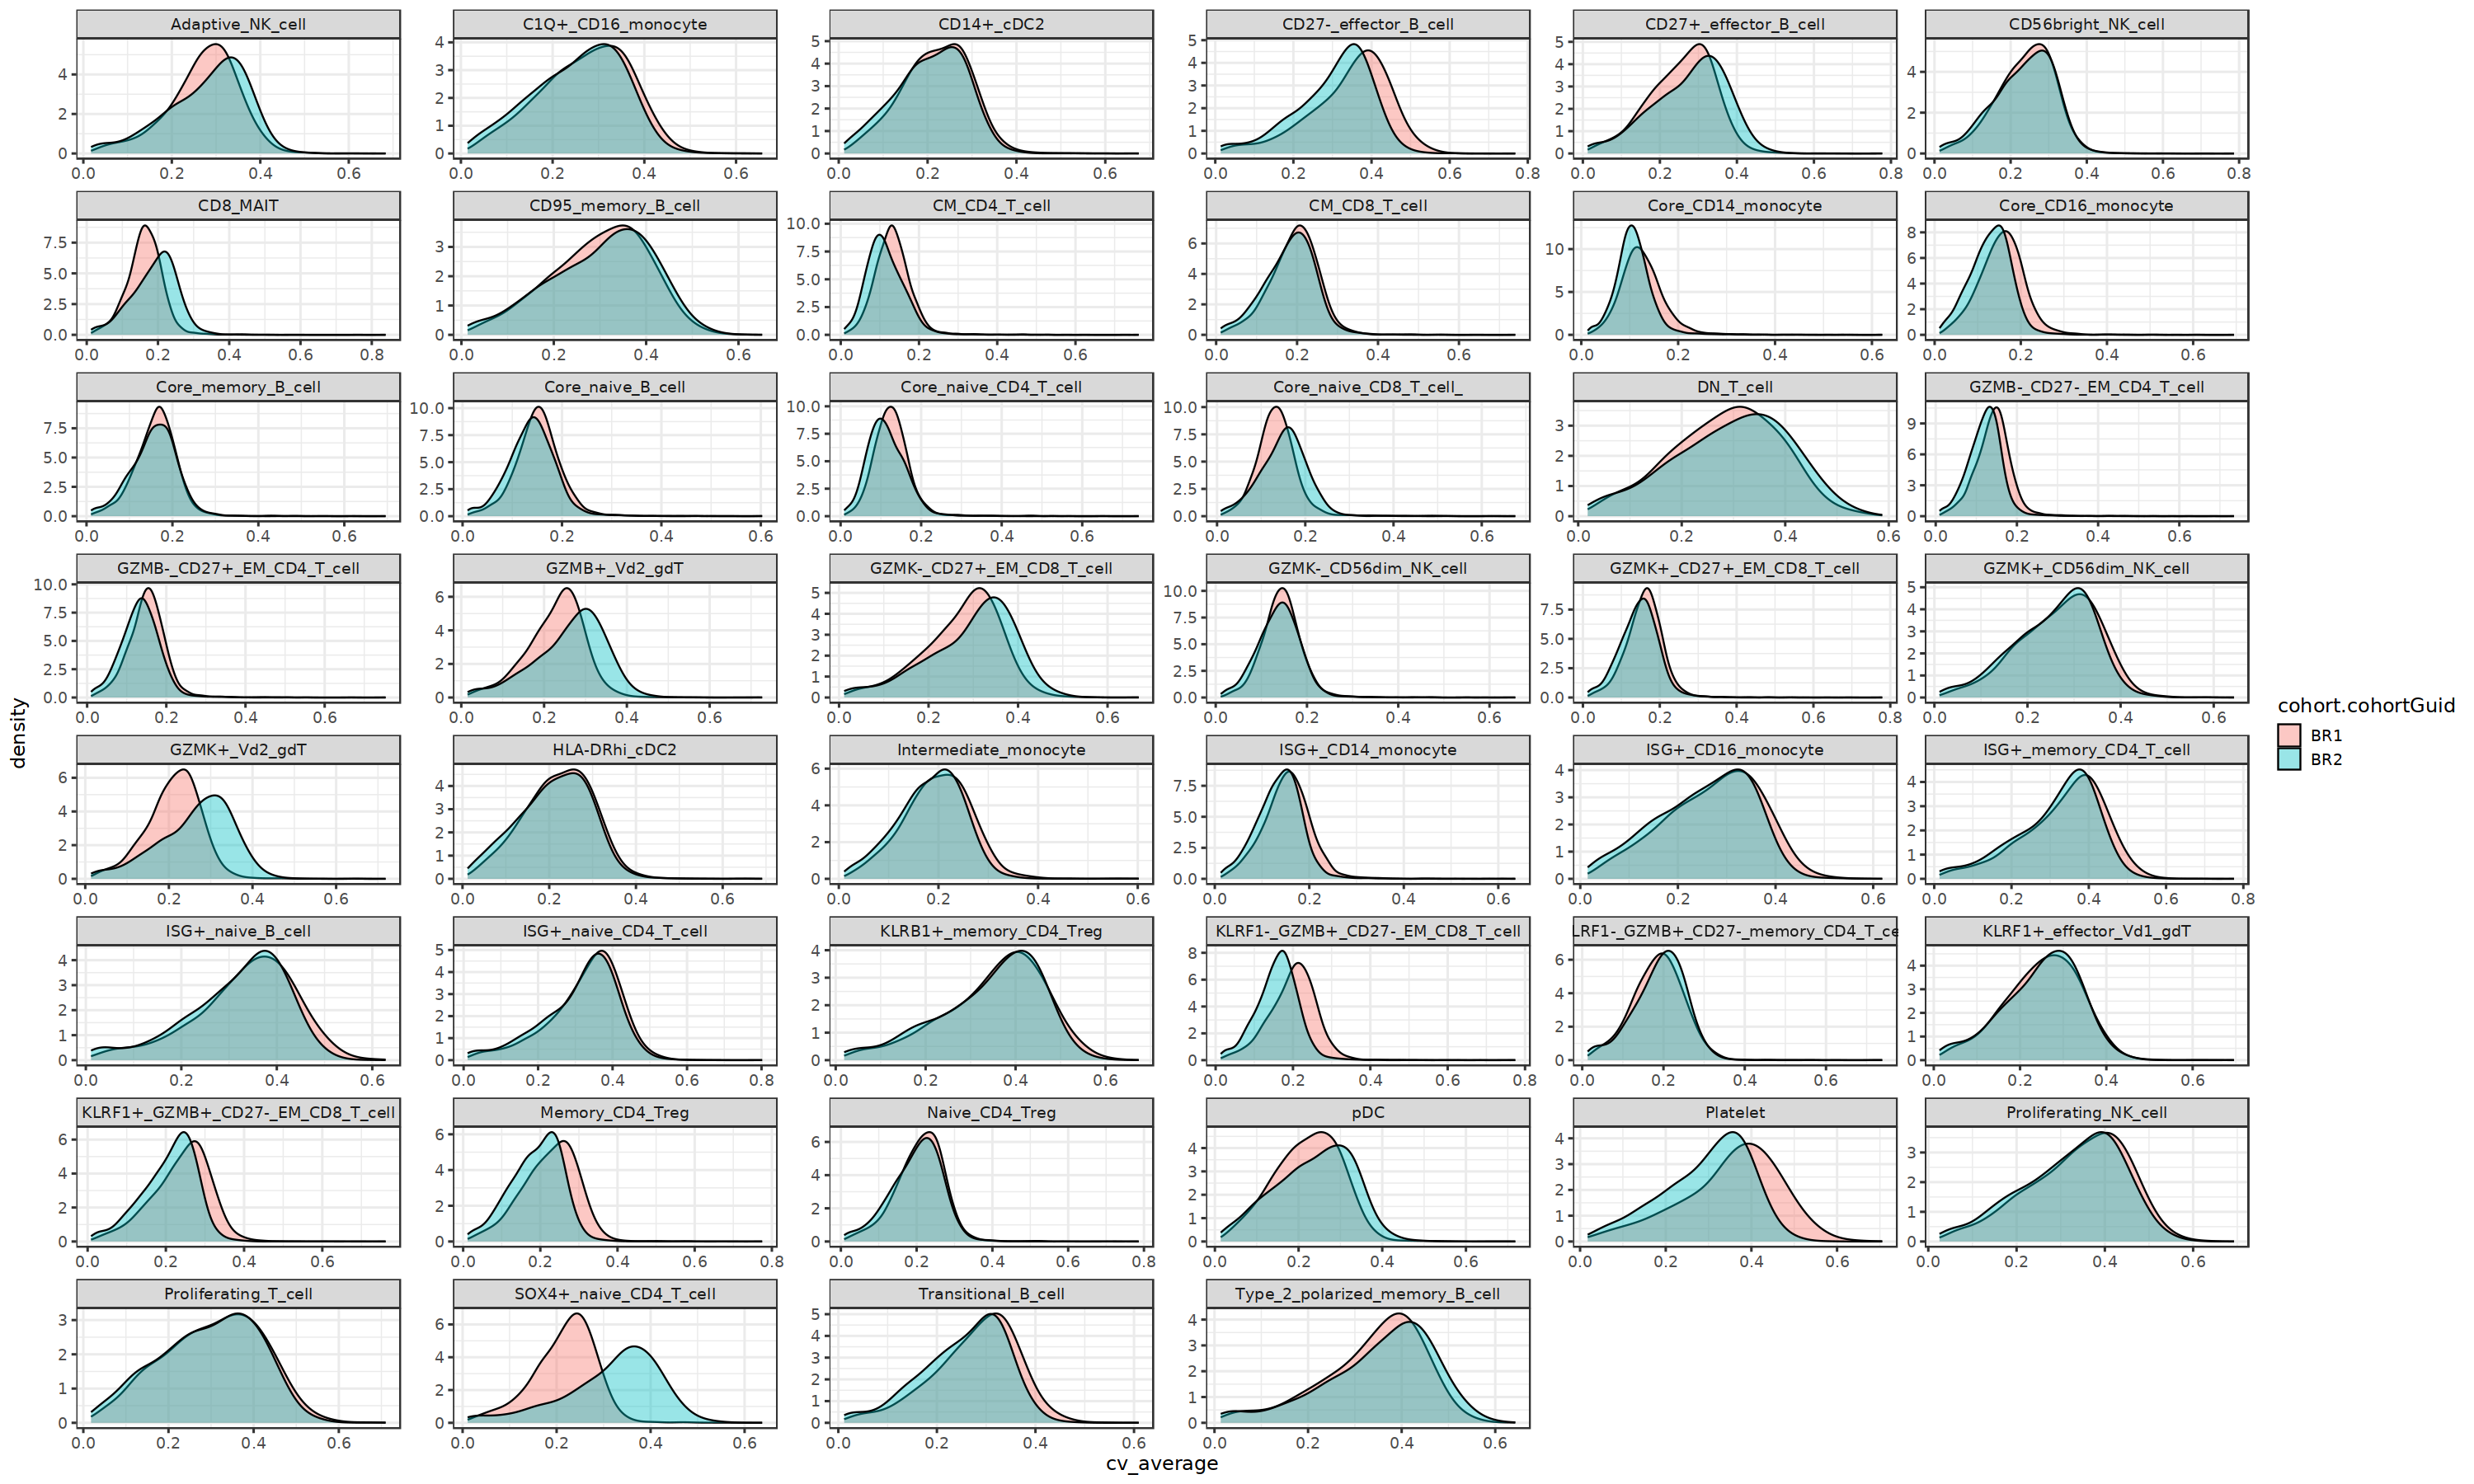

In [58]:
options(repr.plot.width = 25, repr.plot.height = 15)
P<-ggplot(data=df_all_averge%>% filter (celltypes %in% selected_celltype$Var1), aes(x=cv_average,group=cohort.cohortGuid, fill=cohort.cohortGuid)) +
    geom_density(adjust=1.5, alpha=.4) +
    theme_bw(base_size=14)+facet_wrap(~celltypes,ncol=6,scale='free')
P

In [ ]:
library(ggpubr)

In [ ]:
options(repr.plot.width = 20, repr.plot.height = 10)

p1<-ggplot(df_all_averge %>% filter(celltypes%in% c("CD8_MAIT",'CD95_memory_B_cell')), 
       aes(x=mean_average, 
           y=sd_average, 
            color=cohort.cohortGuid)) +
  geom_point(size=0.1,alpha=0.03) + theme_bw(base_size=14)+
  geom_smooth(method='loess', aes(fill=cohort.cohortGuid))+facet_wrap(~celltypes,ncol=12) 
p1

`geom_smooth()` using formula = 'y ~ x'


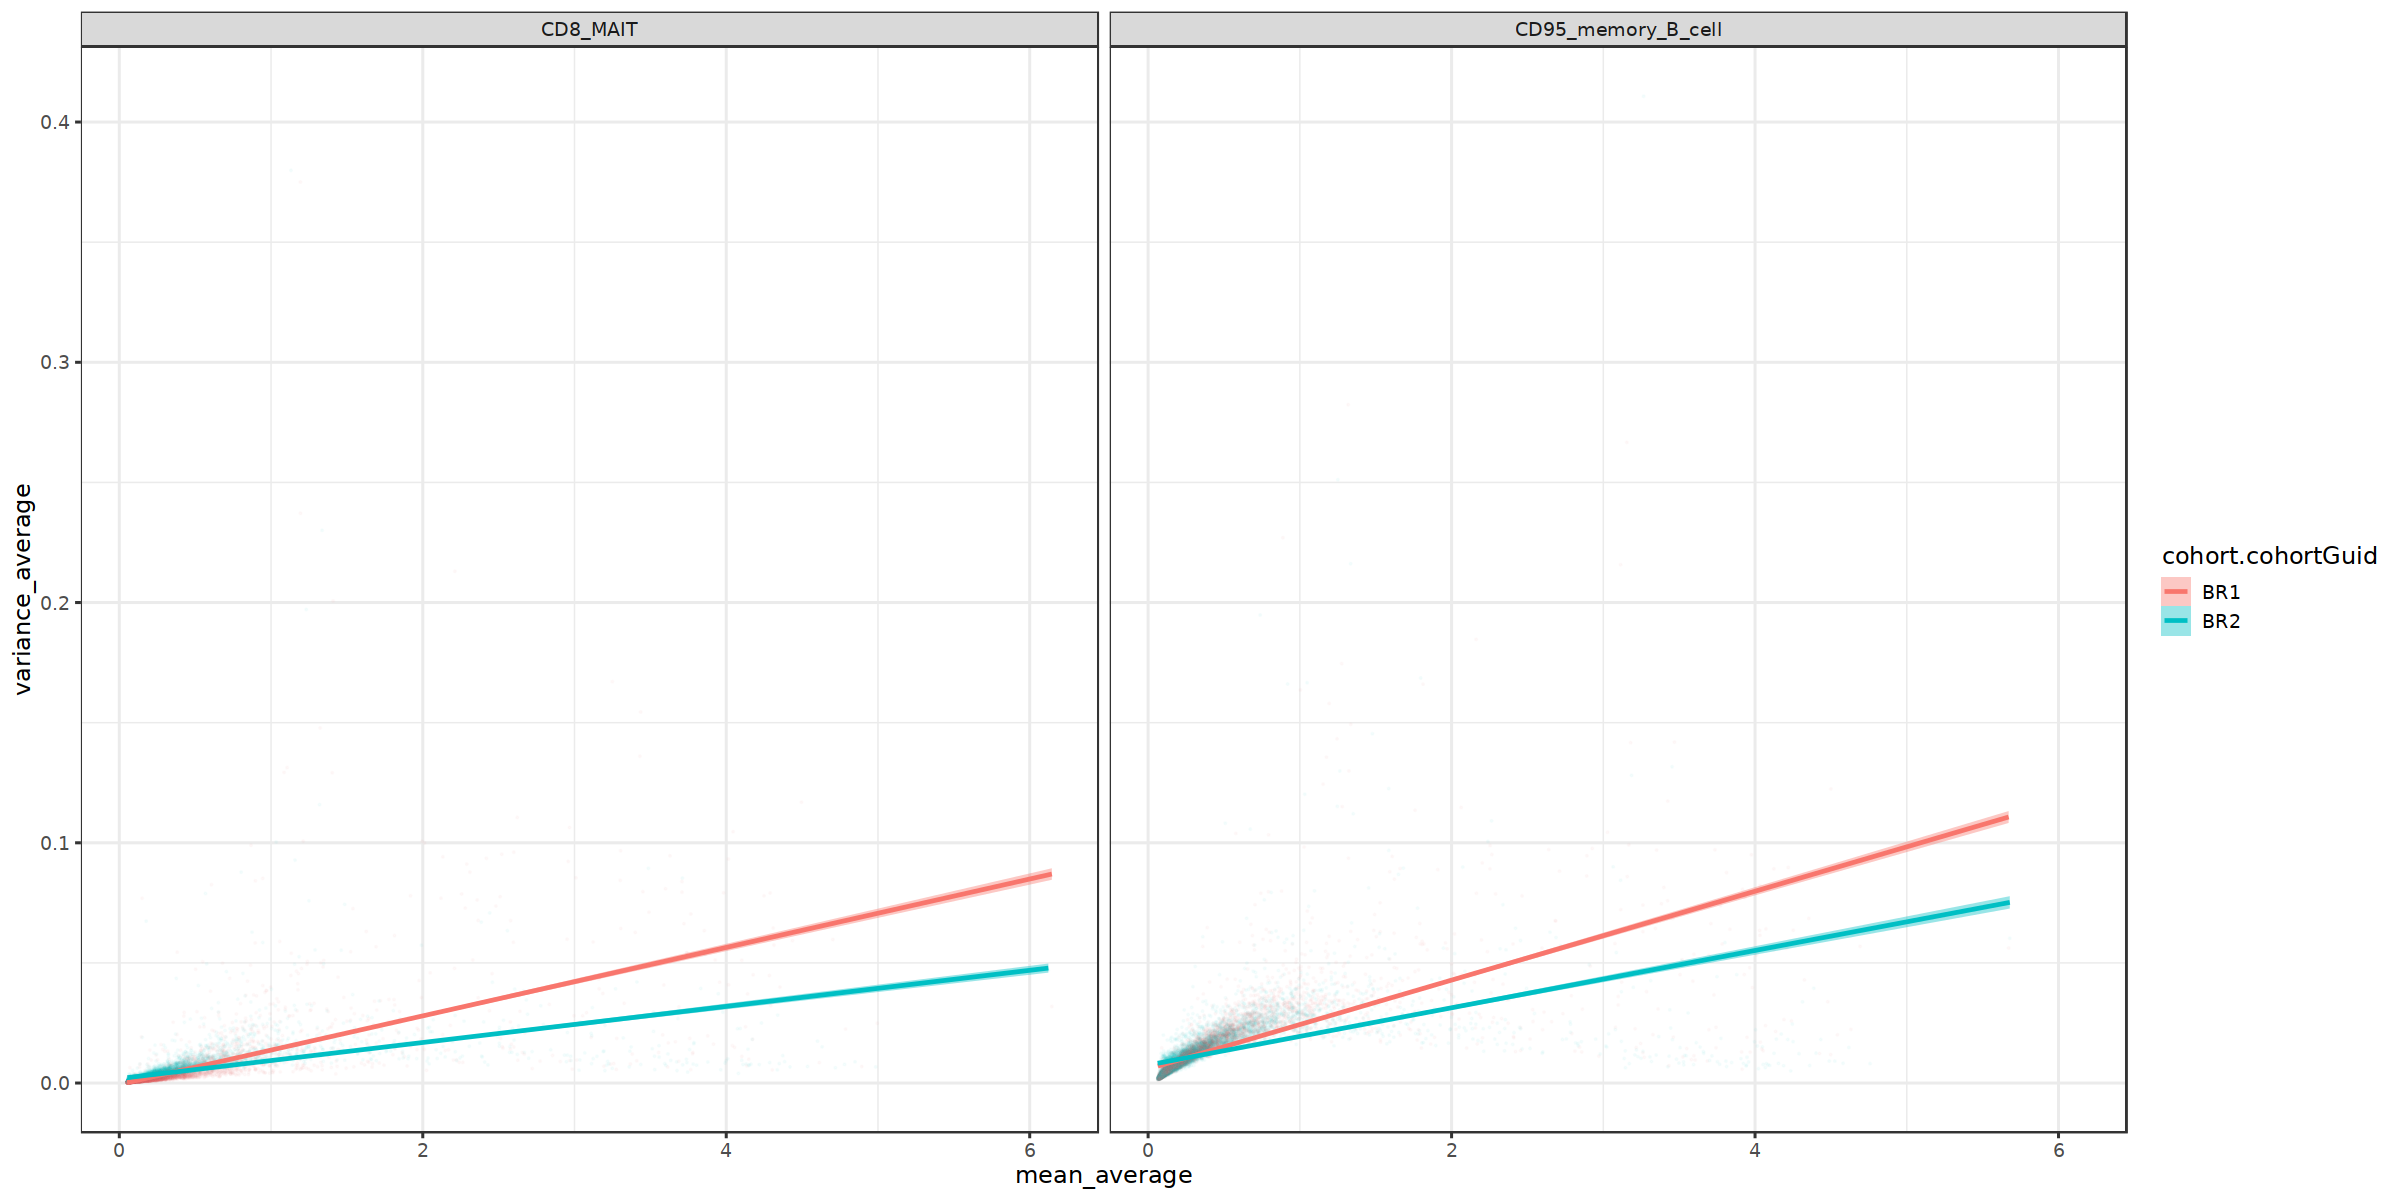

In [50]:
options(repr.plot.width = 20, repr.plot.height = 10)

p1<-ggplot(df_all_averge %>% filter(celltypes%in% c("CD8_MAIT",'CD95_memory_B_cell')), 
       aes(x=mean_average, 
           y=variance_average, 
            color=cohort.cohortGuid)) +
  geom_point(size=0.1,alpha=0.03) + theme_bw(base_size=14)+
  geom_smooth(method='lm', aes(fill=cohort.cohortGuid))+facet_wrap(~celltypes,ncol=12) 
p1

`geom_smooth()` using formula = 'y ~ x'


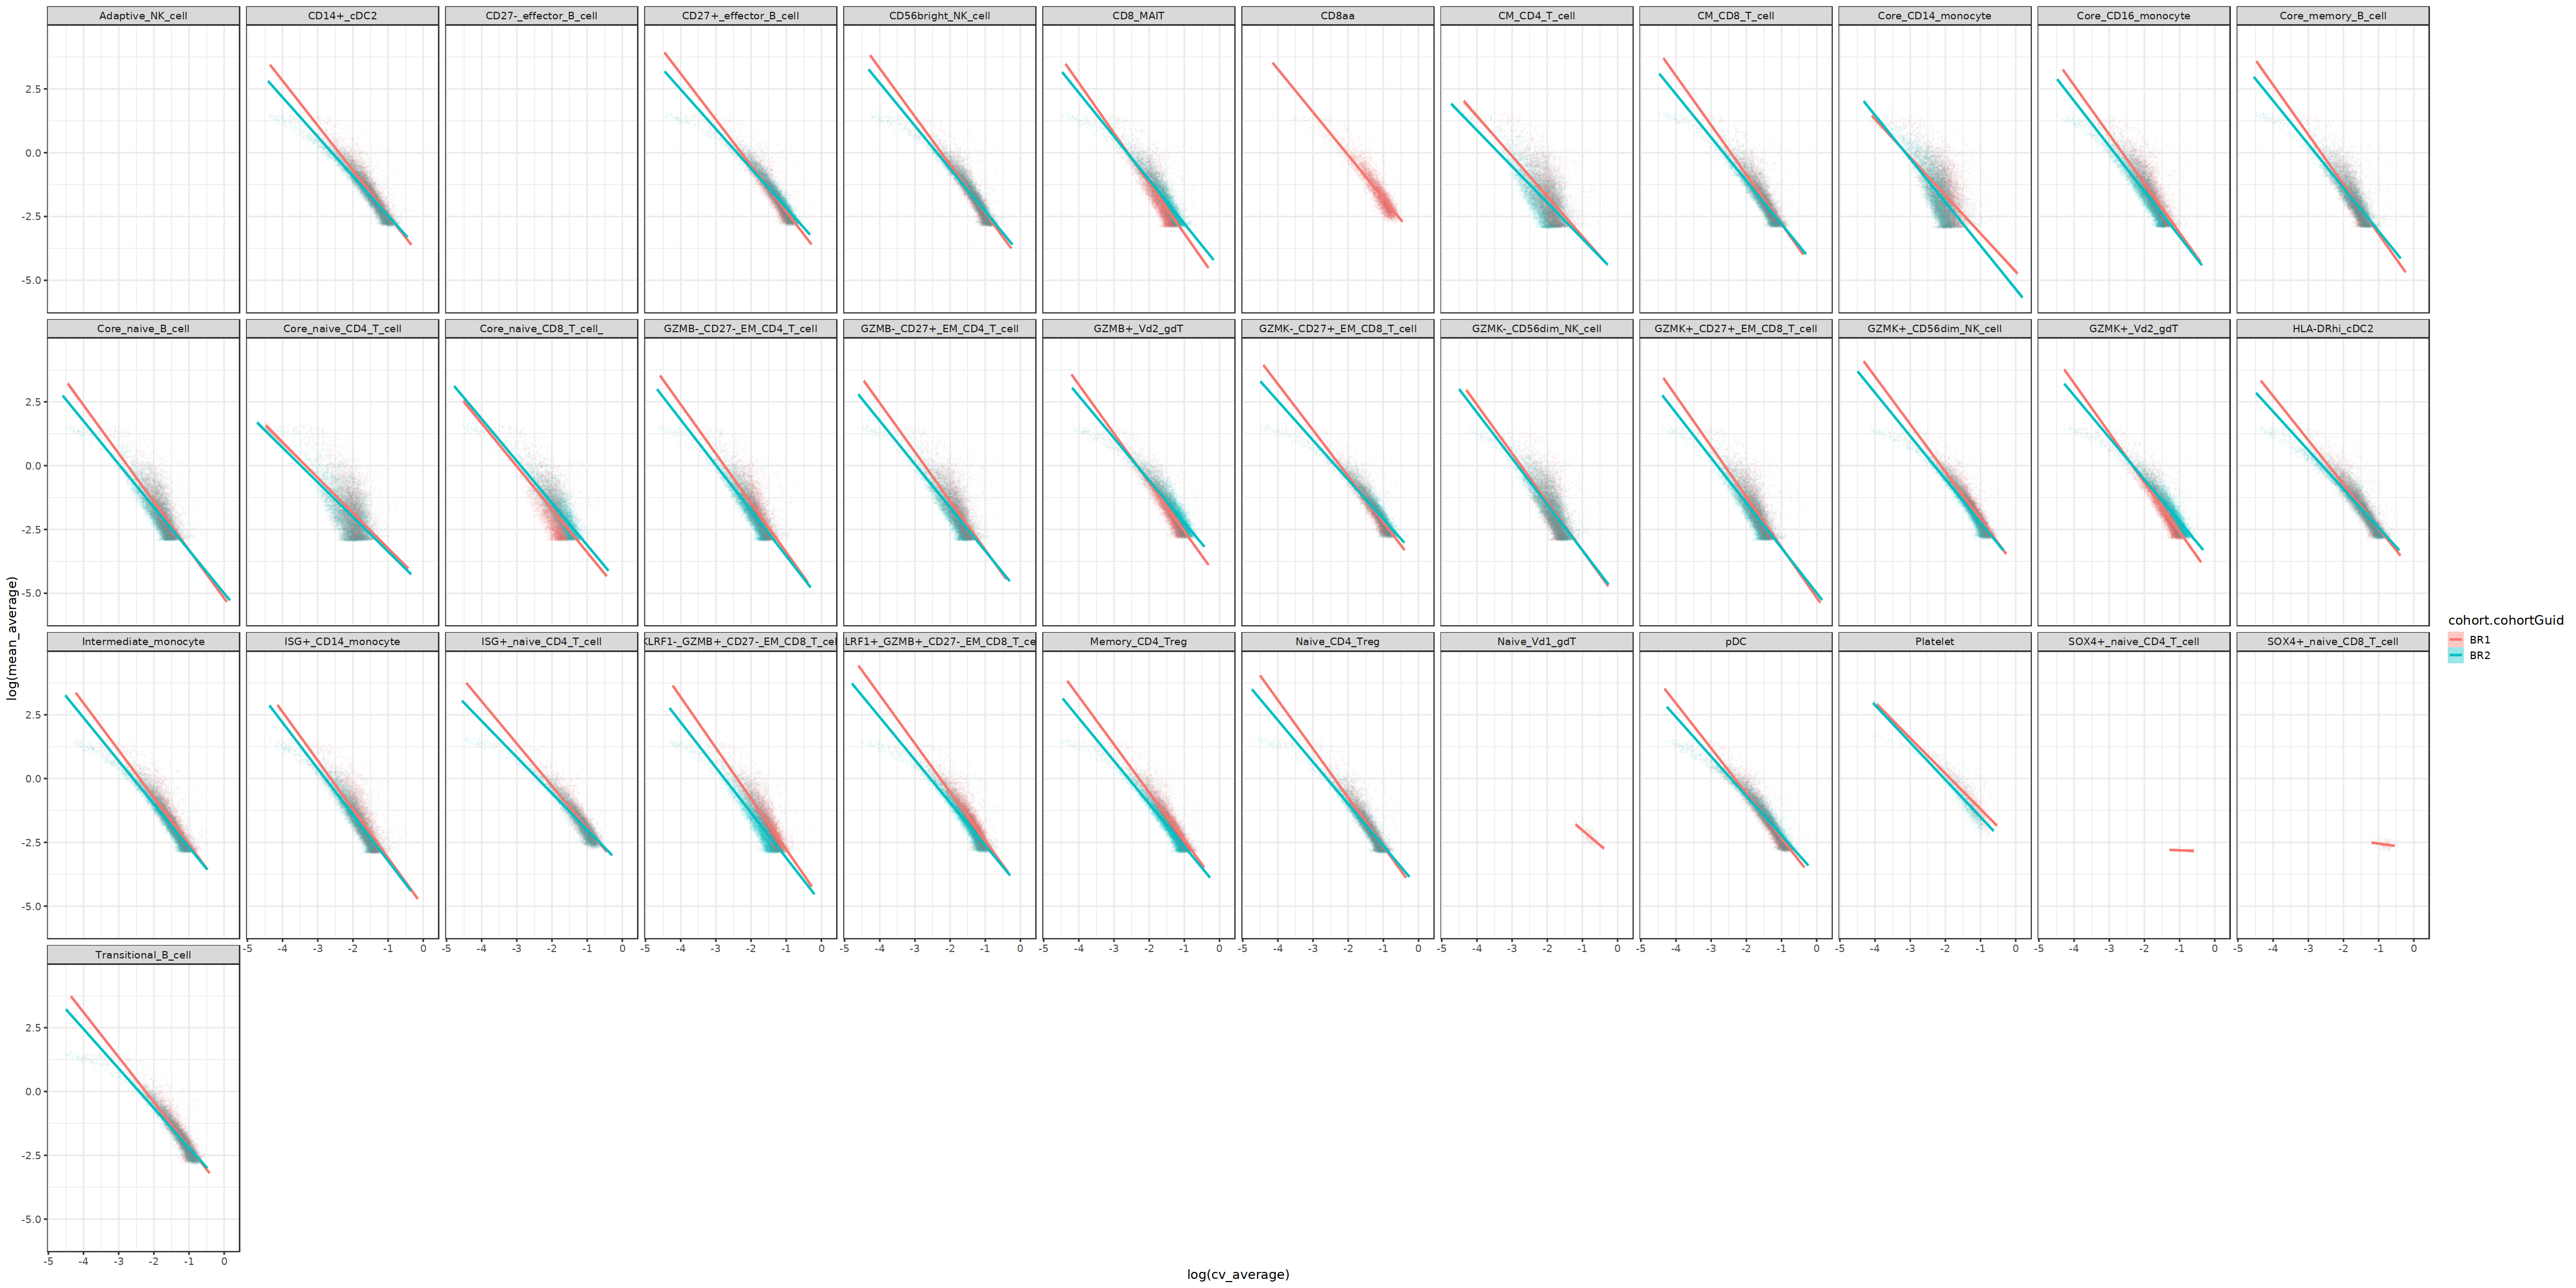

In [74]:
options(repr.plot.width = 40, repr.plot.height = 20)

p1<-ggplot(df_all_averge,#%>% filter(celltypes%in% c("CD8_MAIT",'CD95_memory_B_cell')), 
       aes(x=log(cv_average), 
           y=log(mean_average), 
            color=cohort.cohortGuid)) +
  geom_point(size=0.1,alpha=0.03) + theme_bw(base_size=14)+
  geom_smooth(method='lm', aes(fill=cohort.cohortGuid))+facet_wrap(~celltypes,ncol=12) 
p1

# All non D7 time point

In [78]:
cell_counts<-read.csv('/home//jupyter/BRI_Analysis/scRNA/cell_counts_BRI.csv',check.names = FALSE)
celltypes<-colnames(cell_counts)[3:73]

In [79]:
meta_data<-read.csv('/home//jupyter/BRI_Analysis/scRNA/hise_meta_data_2024-01-23_fixed.csv')
meta_data<-meta_data %>% filter(Covid_exlcusion=='no')

In [80]:
meta<-unique(meta_data[c('subject.subjectGuid','CMV.IgG.Serology.Result.Interpretation','subject.biologicalSex','cohort.cohortGuid')])

In [81]:
colnames(meta)<-c('donor','CMV','Sex','cohort.cohortGuid')

In [82]:
cell_counts<-left_join(meta_data,cell_counts)

Joining with `by = join_by(pbmc_sample_id)`


In [83]:
CV_Res_FILES<-list.files(path = "01A_CV_all_timepoint_nonY2D90/", pattern = "csv", all.files = TRUE,
           full.names = TRUE, recursive = FALSE,
           ignore.case = TRUE, include.dirs = TRUE, no.. = FALSE)

In [84]:
CV_Res_meta<-as.data.frame(CV_Res_FILES)

In [85]:
CV_Res_meta<-CV_Res_meta %>%
  mutate(    after_slash = str_extract(CV_Res_FILES, "(?<=//).+"),
    donor = str_extract(CV_Res_FILES, "(?<=//)[^_]+"),
    celltype = str_extract(after_slash, "(?<=_)[^.]+(?=\\.csv)") )%>%
  select(-after_slash)

In [86]:
CV_Res_meta<-left_join(CV_Res_meta,meta)

Joining with `by = join_by(donor)`


In [87]:
counts_df_minCell <- data.frame()  

for (i in celltypes) {
cell_counts_subset<-cell_counts[c('pbmc_sample_id',i)]
pbmc_sample_id_filtered<-cell_counts_subset[cell_counts_subset[i]>10,]$pbmc_sample_id      
    meta_data_subset <- meta_data %>% filter(pbmc_sample_id %in% pbmc_sample_id_filtered)

    # Check if meta_data_subset is empty
    if (nrow(meta_data_subset) == 0) {
        next  # Skip to the next iteration if no data
    }

    sample_counts <- as.data.frame(table(meta_data_subset$subject.subjectGuid))
    sample_counts$celltypes <- i
    
    colnames(sample_counts) <- c('donor', 'number_of_timepoint_with_minCell', 'celltypes')
    counts_df_minCell <- rbind.fill(counts_df_minCell, sample_counts)
}
counts_df_minCell$celltypes<-gsub(' ','_',counts_df_minCell$celltypes)

In [88]:

df_list<-mclapply(pull(CV_Res_meta['CV_Res_FILES']),function(x){
df<-read.csv(x) %>% filter(mean>=0.1)
return(df)
},mc.cores=60)


In [89]:
df_all<-do.call(rbind, df_list)
df_all<-left_join(df_all,meta)

Joining with `by = join_by(donor)`


In [90]:
df_all<-left_join(df_all,counts_df_minCell)

Joining with `by = join_by(celltypes, donor)`


In [91]:
# filter out samples does not contian 4 time point and genes has zero expression in any of 4 time point

df_all<-df_all %>% filter(number_of_timepoint>5,number_of_timepoint_non_zero_expr>5,number_of_timepoint_with_minCell>5)#%>%


In [92]:
df=as.data.frame(table(df_all$X,df_all$celltypes,df_all$cohort.cohortGuid))
colnames(df)<-c('X',"celltypes",'cohort.cohortGuid','donor_counts')

In [93]:
df_all_averge<-df_all %>% group_by(celltypes,X,cohort.cohortGuid) %>%   
                    dplyr::summarise(cv_average = mean(cv),
                                     mean_average = mean(mean),
                                    variance_average = mean(variance),
                                    sd_average = mean(sd),) 

`summarise()` has grouped output by 'celltypes', 'X'. You can override using
the `.groups` argument.


In [94]:
# filter gene by at least 10 donor in each cohorts

df_all_averge<-left_join(df_all_averge,df)
df_all_averge<-df_all_averge %>%
  group_by(celltypes,X) %>%
  filter(all(donor_counts > 10)) %>%
  ungroup()

Joining with `by = join_by(celltypes, X, cohort.cohortGuid)`


In [95]:
selected_celltype<-as.data.frame(table(df_all_averge$celltypes,df_all_averge$cohort.cohortGuid)) %>%
  group_by(Var1) %>%
  filter(all(Freq > 1000)) %>%
  ungroup()

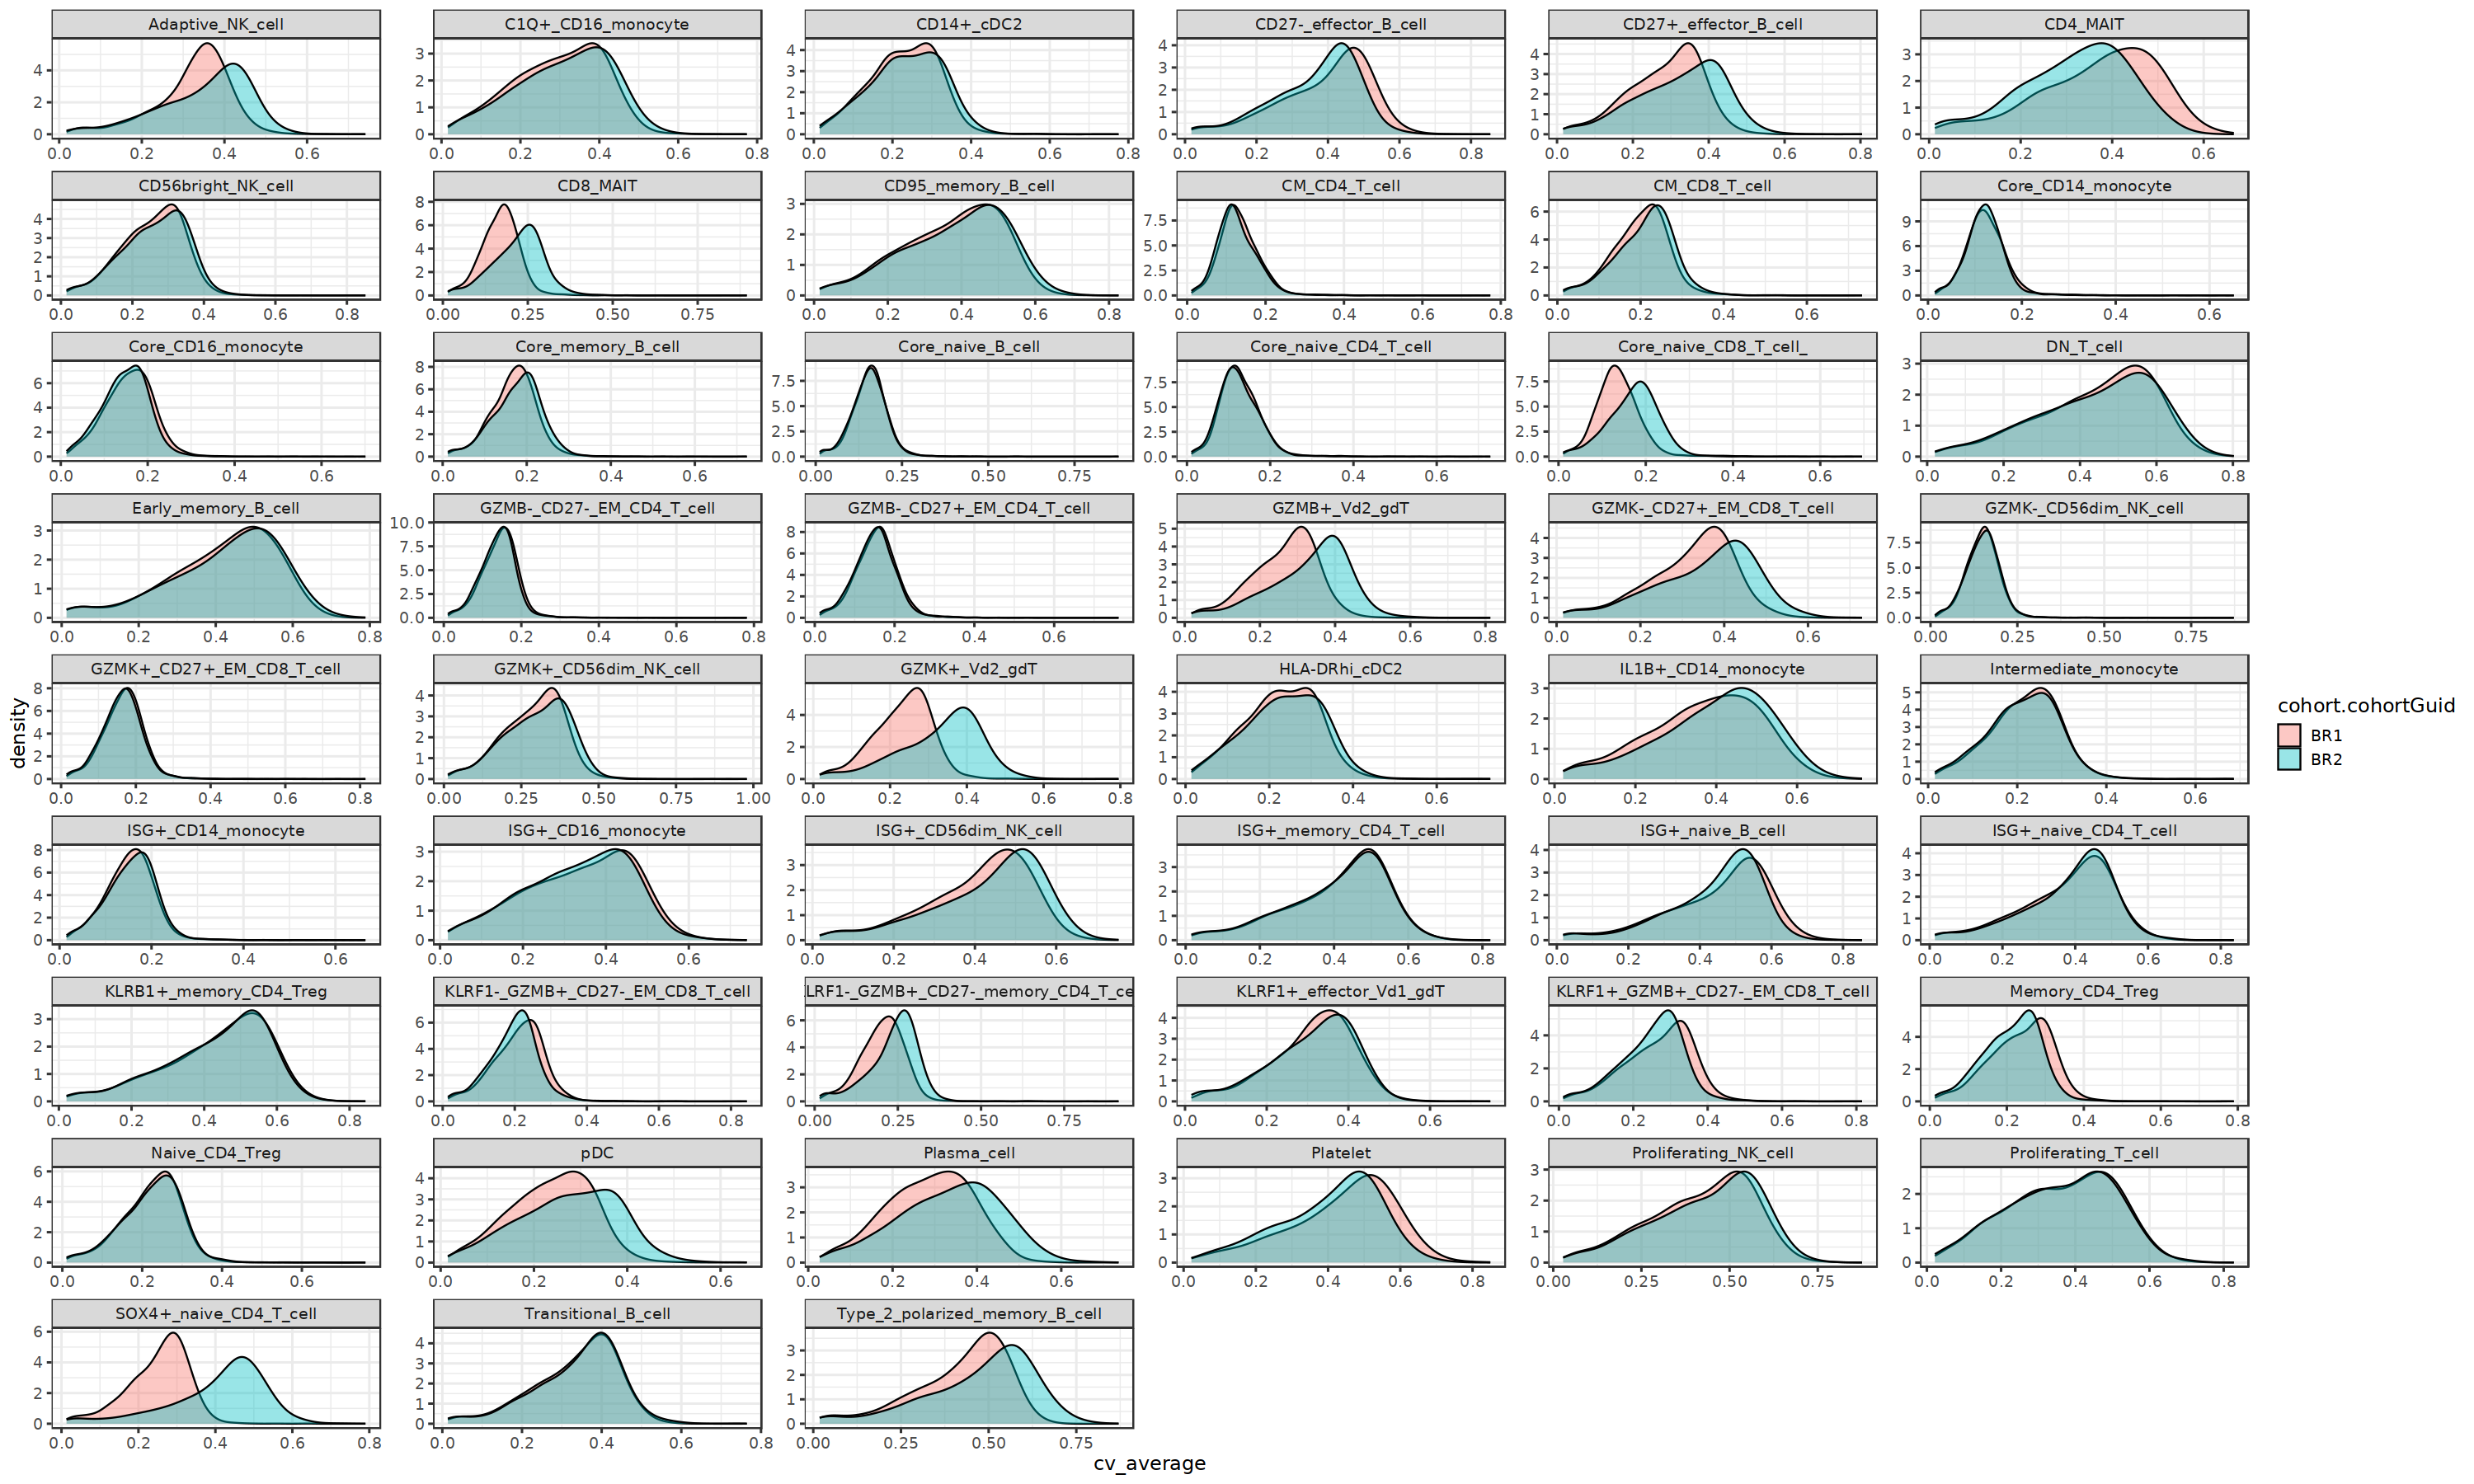

In [96]:
options(repr.plot.width = 25, repr.plot.height = 15)
P<-ggplot(data=df_all_averge%>% filter (celltypes %in% selected_celltype$Var1), aes(x=cv_average,group=cohort.cohortGuid, fill=cohort.cohortGuid)) +
    geom_density(adjust=1.5, alpha=.4) +
    theme_bw(base_size=14)+facet_wrap(~celltypes,ncol=6,scale='free')
P

# Pathway analysis

In [46]:
df_all_averge %>% filter(celltypes=="Core_naive_CD4_T_cell",X=='COX5B')

celltypes,X,cohort.cohortGuid,cv_average,mean_average,variance_average,sd_average,donor_counts
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
Core_naive_CD4_T_cell,COX5B,BR1,0.14751432,0.9296651,0.025284335,0.13225502,37
Core_naive_CD4_T_cell,COX5B,BR2,0.04577641,0.9962653,0.003642917,0.04524416,44


In [47]:
head(df_all_averge)

celltypes,X,cohort.cohortGuid,cv_average,mean_average,variance_average,sd_average,donor_counts
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
Adaptive_NK_cell,A2M-AS1,BR1,0.6008999,0.12679057,0.010491918,0.08054610,15
Adaptive_NK_cell,A2M-AS1,BR2,0.5376502,0.11772234,0.005014707,0.06369949,26
Adaptive_NK_cell,AAAS,BR1,0.4369073,0.06100524,0.001042917,0.02777041,11
Adaptive_NK_cell,AAAS,BR2,0.5087602,0.06408085,0.001193063,0.03269808,19
Adaptive_NK_cell,AAED1,BR1,0.3356969,0.16764916,0.003900896,0.05572000,18
Adaptive_NK_cell,AAED1,BR2,0.4431423,0.16095724,0.005731923,0.07002729,37


In [48]:
log2(0.3976931/0.4832482)

[1] -0.2811088

In [49]:
head(cv_log2fc)

ERROR: Error in eval(expr, envir, enclos): object 'cv_log2fc' not found


In [ ]:
cv_log2fc<- df_all_averge %>%
  group_by(celltypes, X) %>%
  filter(n() == 2) %>%
  arrange(celltypes, X, cohort.cohortGuid) %>%
  summarise(log2fc = log2(last(cv_average) / first(cv_average)))

In [ ]:
cv_log2fc_subset<-cv_log2fc %>% filter(celltypes=="Core_naive_CD4_T_cell") %>% arrange(desc(log2fc))

In [ ]:
head(cv_log2fc_subset)

In [ ]:
tail(cv_log2fc_subset)

In [ ]:
library(fgsea)

In [ ]:
pathways_database <- gmtPathways('c2.cp.v7.2.symbols.gmt')


In [ ]:
fgsea_input<-deframe(cv_log2fc_subset[c('X','log2fc')])

In [ ]:
fgseaResults <- fgsea(pathways =pathways_database ,
                      stats = fgsea_input,
                      minSize = 15,
                      maxSize = 500,
                      nperm = 1000)

In [ ]:
tail(fgsea_input)

In [ ]:
fgseaResults %>% filter(padj<0.05) %>% arrange(padj)

In [42]:
library(car)

# Example data - replace this with your actual data
# Creating a data frame with variances and group labels
variances <- c(1.2, 1.4, 1.3, 1.5, 2.1, 2.3, 2.2, 2.4) # Sample variance values
groups <- as.factor(c("Group1", "Group1", "Group1", "Group1", 
                      "Group2", "Group2", "Group2", "Group2")) # Group labels

data <- data.frame(variances, groups)

# Perform Levene's Test
leveneTest(variances ~ groups, data = data)

Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode




,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,1,6.021782e-30,1
,6,NA,NA
